In [178]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from scipy import stats

In [164]:
# Load the datasets
individual_path = '/app/intermediate/individual_raw.csv'
consensus_path = '/app/intermediate/consensus_raw.csv'

individual_df = pd.read_csv(individual_path)
consensus_df = pd.read_csv(consensus_path)

# Convert ratings to integers
individual_df['rating'] = individual_df['rating'].astype('Int64')

# Calculate majority rating for consensus
rating_cols = ['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']
consensus_df['majority_rating'] = consensus_df[rating_cols].idxmax(axis=1).str.extract('(\d+)').astype(int)

print("Individual dataset shape:", individual_df.shape)
print("Consensus dataset shape:", consensus_df.shape)
print("\nIndividual columns:", individual_df.columns.tolist())
print("Consensus columns:", consensus_df.columns.tolist())

Individual dataset shape: (3901, 2)
Consensus dataset shape: (609, 7)

Individual columns: ['text', 'rating']
Consensus columns: ['text', 'rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5', 'majority_rating']


In [165]:
# Basic exploration
print("Individual dataset info:")
print(individual_df.info())
print("\nConsensus dataset info:")
print(consensus_df.info())

print("\nIndividual rating distribution:")
print(individual_df['rating'].value_counts().sort_index())

print("\nConsensus sample:")
print(consensus_df.head())

Individual dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901 entries, 0 to 3900
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3883 non-null   object
 1   rating  3747 non-null   Int64 
dtypes: Int64(1), object(1)
memory usage: 64.9+ KB
None

Consensus dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609 entries, 0 to 608
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             609 non-null    object
 1   rating_1         609 non-null    int64 
 2   rating_2         609 non-null    int64 
 3   rating_3         609 non-null    int64 
 4   rating_4         609 non-null    int64 
 5   rating_5         609 non-null    int64 
 6   majority_rating  609 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 33.4+ KB
None

Individual rating distribution:
rating
1     200
2     450
3     816
4    1122

In [166]:
# Add text features
individual_df['text_length'] = individual_df['text'].str.len()
individual_df['word_count'] = individual_df['text'].str.split().str.len()

# For consensus, calculate MAE (Mean Absolute Error)
rating_cols = ['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']
consensus_df['total_ratings'] = consensus_df[rating_cols].sum(axis=1)
consensus_df['rating_mae'] = consensus_df.apply(lambda row: sum([row[f'rating_{i}'] * abs(i - row['majority_rating']) for i in range(1,6)]) / row['total_ratings'] if row['total_ratings'] > 0 else np.nan, axis=1)

consensus_df['text_length'] = consensus_df['text'].str.len()
consensus_df['word_count'] = consensus_df['text'].str.split().str.len()

print("Individual text length stats:")
print(individual_df['text_length'].describe())
print("\nConsensus majority rating stats:")
print(consensus_df['majority_rating'].describe())

Individual text length stats:
count    3883.000000
mean      402.132372
std       505.010272
min         2.000000
25%       162.000000
50%       298.000000
75%       494.000000
max      9223.000000
Name: text_length, dtype: float64

Consensus majority rating stats:
count    609.000000
mean       3.494253
std        1.231595
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: majority_rating, dtype: float64


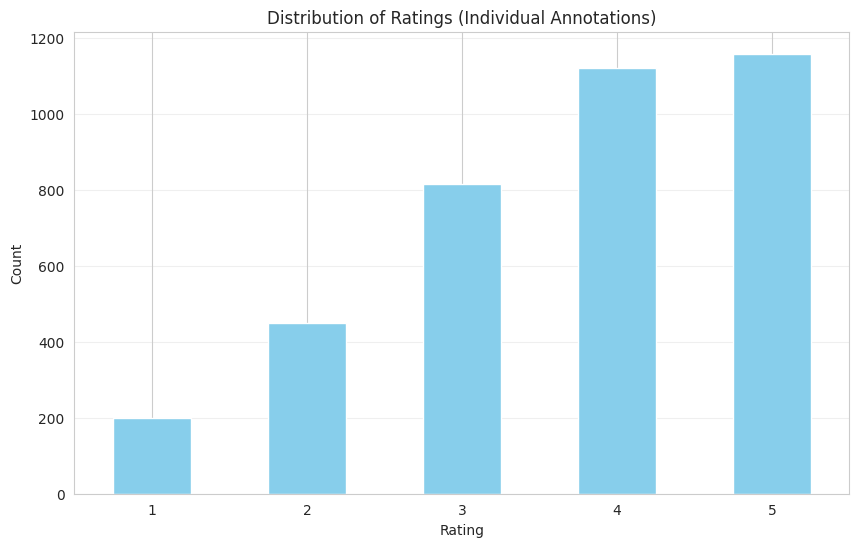

In [167]:
# Plot rating distribution for individual
plt.figure(figsize=(10,6))
individual_df['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings (Individual Annotations)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

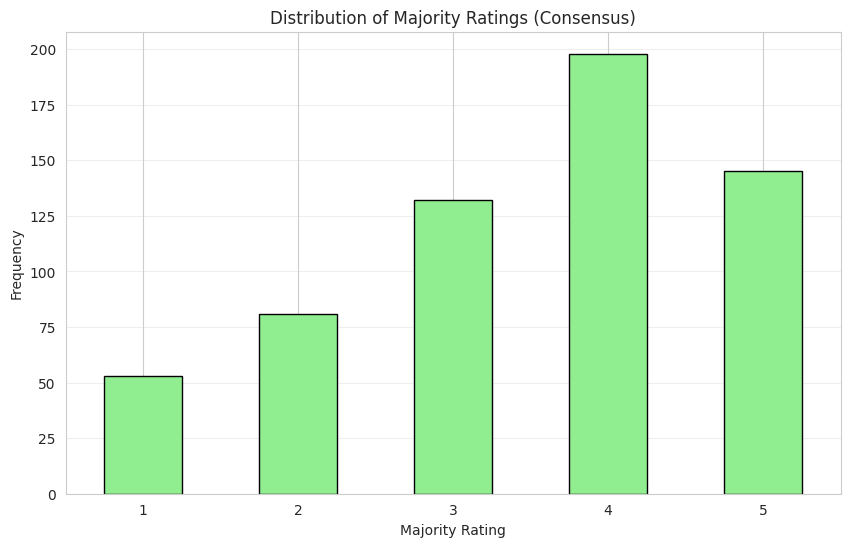

In [168]:
# Plot majority rating distribution for consensus
plt.figure(figsize=(10,6))
consensus_df['majority_rating'].value_counts().sort_index().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Distribution of Majority Ratings (Consensus)')
plt.xlabel('Majority Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

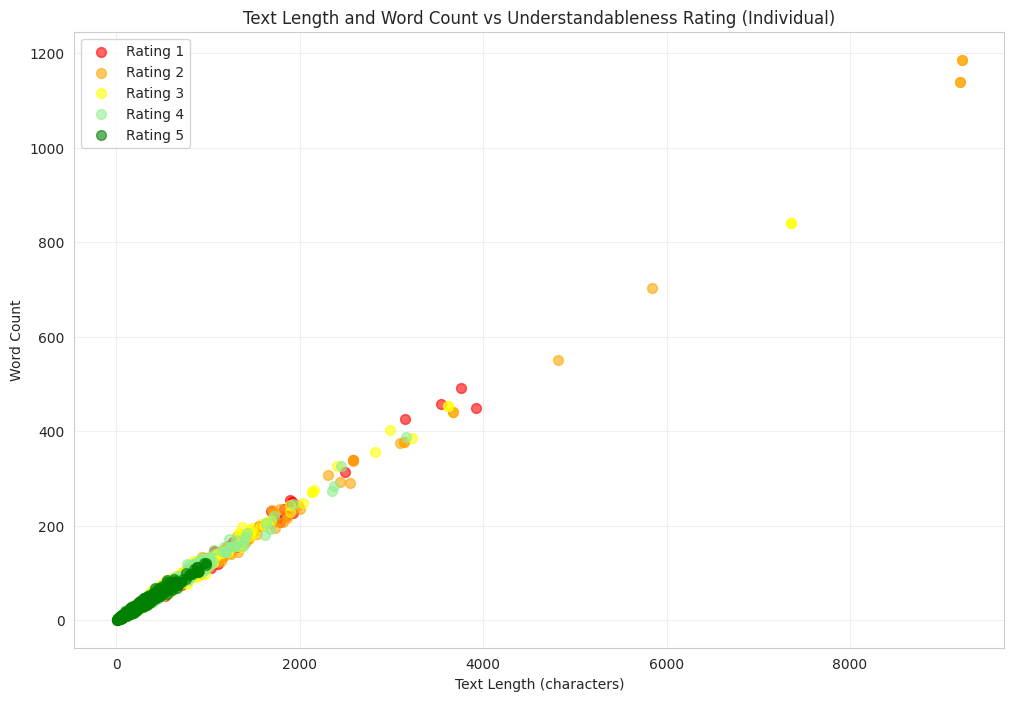

In [169]:
# Scatter plot: text length vs rating (individual)
plt.figure(figsize=(12,8))
colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']
for rating in range(1,6):
    subset = individual_df[individual_df['rating'] == rating]
    plt.scatter(subset['text_length'], subset['word_count'], color=colors[rating-1], alpha=0.6, label=f'Rating {rating}', s=50)
plt.title('Text Length and Word Count vs Understandableness Rating (Individual)')
plt.xlabel('Text Length (characters)')
plt.ylabel('Word Count')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

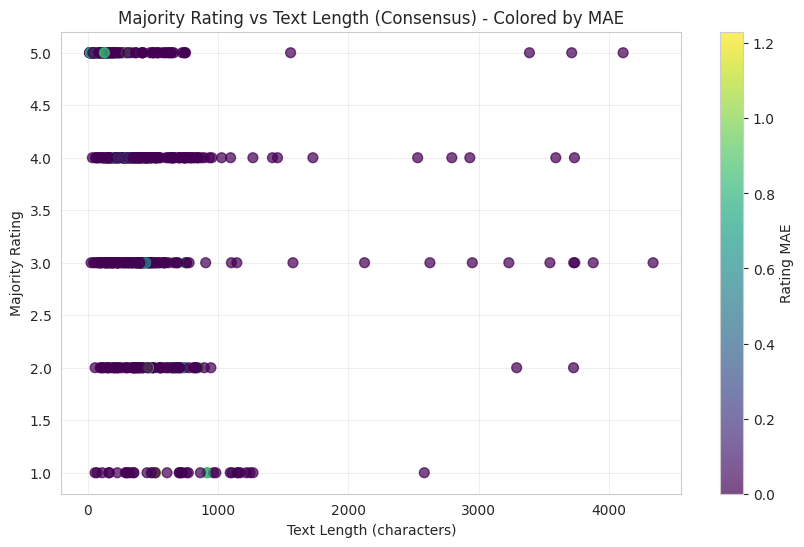

In [170]:
# Scatter plot: majority rating vs text length (consensus)
plt.figure(figsize=(10,6))
plt.scatter(consensus_df['text_length'], consensus_df['majority_rating'], alpha=0.7, c=consensus_df['rating_mae'], cmap='viridis', s=50)
plt.colorbar(label='Rating MAE')
plt.title('Majority Rating vs Text Length (Consensus) - Colored by MAE')
plt.xlabel('Text Length (characters)')
plt.ylabel('Majority Rating')
plt.grid(alpha=0.3)
plt.show()

<Figure size 1000x600 with 0 Axes>

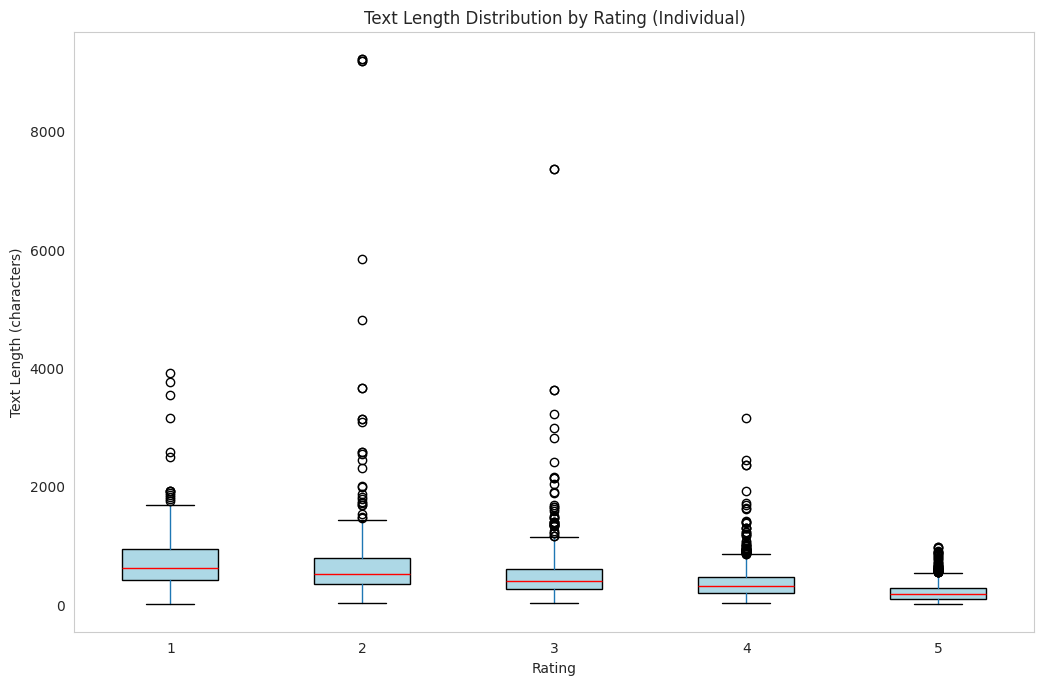

In [171]:
# Box plot of text length by rating (individual)
plt.figure(figsize=(10,6))
individual_df.boxplot(column='text_length', by='rating', grid=False, patch_artist=True, 
                     boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
plt.title('Text Length Distribution by Rating (Individual)')
plt.suptitle('')
plt.xlabel('Rating')
plt.ylabel('Text Length (characters)')
plt.show()

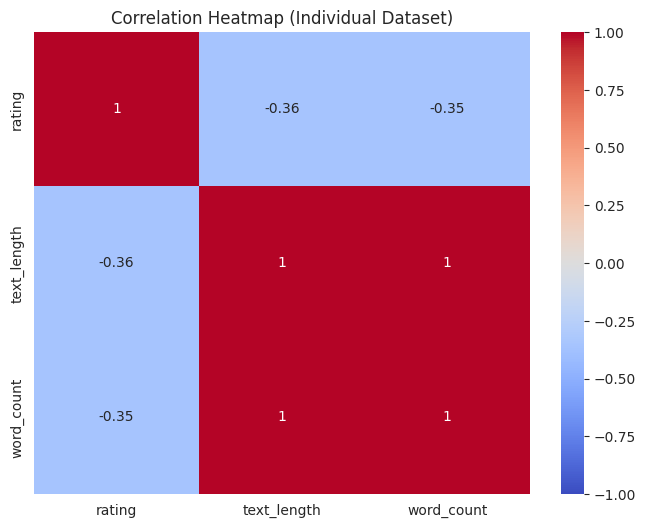

In [172]:
# Correlation heatmap for individual
import seaborn as sns
corr_individual = individual_df[['rating', 'text_length', 'word_count']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_individual, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Individual Dataset)')
plt.show()

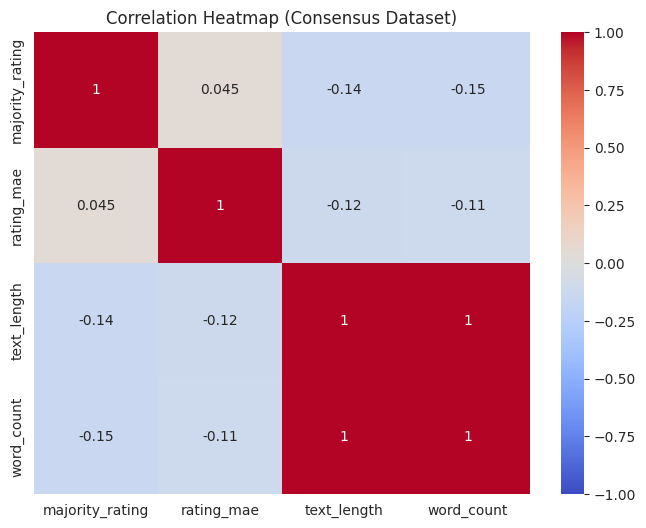

In [173]:
# Correlation heatmap for consensus
corr_consensus = consensus_df[['majority_rating', 'rating_mae', 'text_length', 'word_count']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_consensus, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Consensus Dataset)')
plt.show()

Rating 1 - Top 10 words: [('a', 1845), ('az', 754), ('és', 431), ('nem', 247), ('vagy', 243), ('hogy', 127), ('1', 109), ('szerződés', 88), ('ha', 87), ('szóló', 86)]
Rating 2 - Top 10 words: [('a', 4014), ('az', 1503), ('és', 836), ('vagy', 510), ('nem', 485), ('hogy', 302), ('ha', 215), ('szolgáltató', 184), ('által', 176), ('illetve', 166)]
Rating 3 - Top 10 words: [('a', 5227), ('az', 1918), ('és', 1005), ('vagy', 734), ('nem', 692), ('hogy', 325), ('ha', 286), ('által', 266), ('szolgáltató', 257), ('illetve', 245)]
Rating 4 - Top 10 words: [('a', 5540), ('az', 2004), ('és', 1018), ('vagy', 785), ('nem', 699), ('hogy', 367), ('szolgáltató', 281), ('által', 260), ('esetén', 258), ('felhasználó', 257)]
Rating 5 - Top 10 words: [('a', 3299), ('az', 1108), ('és', 602), ('nem', 409), ('vagy', 348), ('hogy', 205), ('felhasználó', 202), ('2', 177), ('1', 173), ('esetén', 172)]


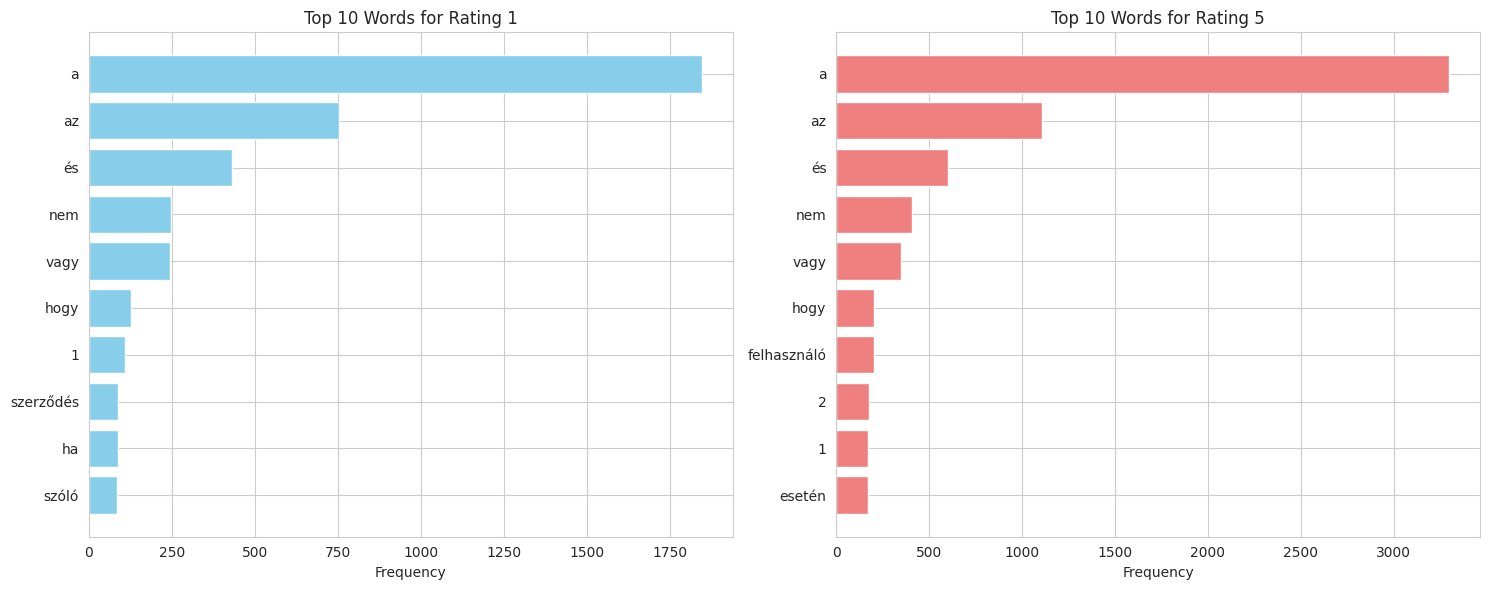

In [174]:
# Most common words per rating (individual)
from collections import Counter
import re

def get_words(text):
    return re.findall(r'\b\w+\b', text.lower())

for rating in range(1,6):
    texts = individual_df[individual_df['rating'] == rating]['text']
    all_words = []
    for text in texts:
        all_words.extend(get_words(text))
    word_freq = Counter(all_words)
    common = word_freq.most_common(10)
    print(f"Rating {rating} - Top 10 words: {common}")

# Plot top words for rating 1 and 5
fig, axes = plt.subplots(1, 2, figsize=(15,6))

for i, rating in enumerate([1,5]):
    texts = individual_df[individual_df['rating'] == rating]['text']
    all_words = []
    for text in texts:
        all_words.extend(get_words(text))
    word_freq = Counter(all_words)
    top_words = word_freq.most_common(10)
    words, counts = zip(*top_words)
    axes[i].barh(words[::-1], counts[::-1], color='skyblue' if rating==1 else 'lightcoral')
    axes[i].set_title(f'Top 10 Words for Rating {rating}')
    axes[i].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

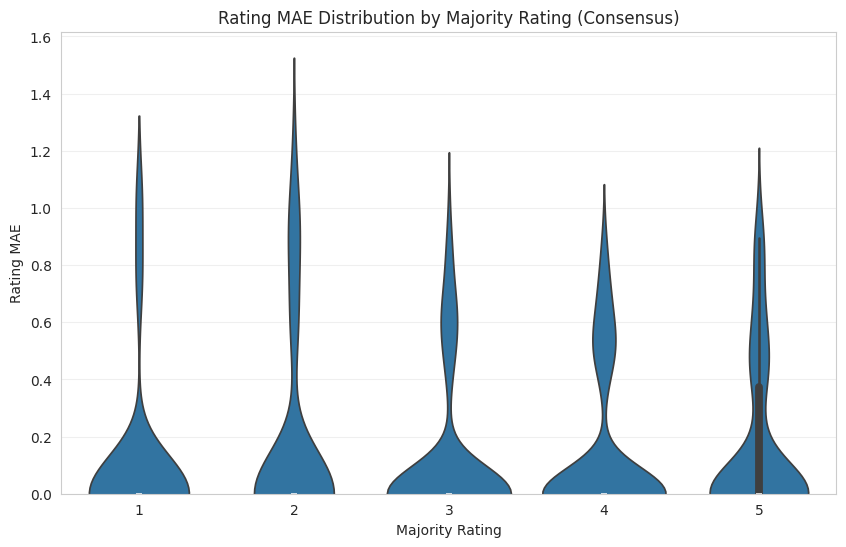

In [176]:
# Violin plot: MAE by majority rating
plt.figure(figsize=(10,6))
sns.violinplot(x='majority_rating', y='rating_mae', data=consensus_df)
plt.title('Rating MAE Distribution by Majority Rating (Consensus)')
plt.xlabel('Majority Rating')
plt.ylabel('Rating MAE')
plt.ylim(bottom=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

Individual duplicates: 390
Consensus duplicates: 0
Sample duplicate texts in individual:
                                                text  rating  text_length  \
0  1. Szerződés tárgya\nA Vállalkozó az alvállalk...       3        297.0   
1  2.3. A vállalkozói díj magában foglalja a Váll...       4       1296.0   
2  2.4. Vállalkozó  köteles az átadott tervek mér...       4        501.0   
3  3.1. A Szerződő felek megállapodnak abban, hog...       3        816.0   
4  3.4. A szerződés tárgyát képező feladat akkor ...       3        220.0   

   word_count  
0        34.0  
1       158.0  
2        61.0  
3       101.0  
4        26.0  
Outliers in individual text length: 0
Outliers in consensus text length: 19


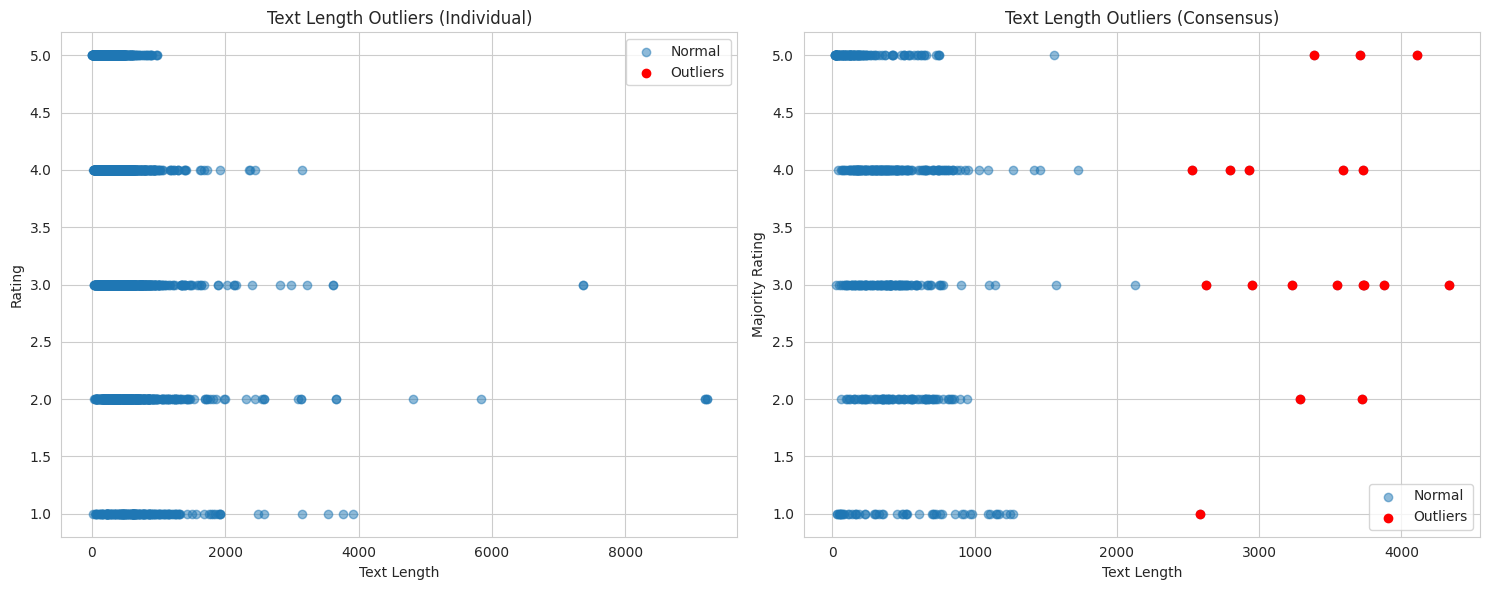

In [177]:
# Check for duplicates
individual_duplicates = individual_df.duplicated(subset='text').sum()
consensus_duplicates = consensus_df.duplicated(subset='text').sum()

print(f"Individual duplicates: {individual_duplicates}")
print(f"Consensus duplicates: {consensus_duplicates}")

# If there are duplicates, show some
if individual_duplicates > 0:
    print("Sample duplicate texts in individual:")
    print(individual_df[individual_df.duplicated(subset='text', keep=False)].head())

# Outliers in text length
from scipy import stats
z_scores_ind = stats.zscore(individual_df['text_length'])
outliers_ind = individual_df[abs(z_scores_ind) > 3]
print(f"Outliers in individual text length: {len(outliers_ind)}")

z_scores_con = stats.zscore(consensus_df['text_length'])
outliers_con = consensus_df[abs(z_scores_con) > 3]
print(f"Outliers in consensus text length: {len(outliers_con)}")

# Plot outliers
fig, axes = plt.subplots(1,2, figsize=(15,6))
axes[0].scatter(individual_df['text_length'], individual_df['rating'], alpha=0.5, label='Normal')
axes[0].scatter(outliers_ind['text_length'], outliers_ind['rating'], color='red', label='Outliers')
axes[0].set_title('Text Length Outliers (Individual)')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Rating')
axes[0].legend()

axes[1].scatter(consensus_df['text_length'], consensus_df['majority_rating'], alpha=0.5, label='Normal')
axes[1].scatter(outliers_con['text_length'], outliers_con['majority_rating'], color='red', label='Outliers')
axes[1].set_title('Text Length Outliers (Consensus)')
axes[1].set_xlabel('Text Length')
axes[1].set_ylabel('Majority Rating')
axes[1].legend()

plt.tight_layout()
plt.show()